# Question 1:  Pose Graph Optimization for 1D SLAM

A solved example for 1D SLAM which optimizes for pose variables using weighted least squares method (Gauss Newton) has been explained in the class. You can view it at `examples/1D-SLAM.ipynb`. Your first task is to code this from scratch.

For this section, you have to calculate Jacobian analytically yourself and use it. However, you can check how correct it is using `jax`'s `jacobian`. Its usage is explained in the supplementary notebook (`examples/`).

## How to get started?

1. Go through the example and understand the optimization procedure.
2. Generate the data as in the example.
3. Write the derivatives of the function with respect to the constraints
4. Create the final jacobian and write the update steps using Gauss Newton

This tiny example will help make sense of the next question, as it's largely just an extension of this.

Finally, plot the loop closure constraint, poses, and error at every iteration as well. Since this is a one dimensional example, you can just assume x = y.

In [130]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import jacfwd
plt.style.use('seaborn')

In [131]:
#  Code!
# we will have following steps:
# data generation
# getting info matrix from covariance
# residual 
# jacobian calc
# optimization
# plotting

#data generation
gt_u=[1,1,1,-3,0]
obs_u=[1.1,1,1.1,-2.7,0]
gt_x=[0]
odo_x=[0.0]

def data_generation():
    for _ in range(len(gt_u)-1):
        gt_x.append(gt_u[_]+gt_x[_])
        odo_x.append(obs_u[_]+odo_x[_])

def view_initials():
    # print ("Ground Truth :")
    print("U: ",gt_u)
    print("obs u :" , obs_u)
    print("X: ",gt_x)
    print("Odo x :",odo_x)

data_generation()
view_initials()



U:  [1, 1, 1, -3, 0]
obs u : [1.1, 1, 1.1, -2.7, 0]
X:  [0, 1, 2, 3, 0]
Odo x : [0.0, 1.1, 2.1, 3.2, 0.5]


In [132]:
# info matrix from covariance matrix
# covariance_matrix=np.array([
#     [0.01, 0, 0, 0, 0, 0],
#     [0, 0.01, 0, 0, 0, 0],
#     [0, 0, 0.01, 0, 0, 0],
#     [0, 0, 0, 0.01, 0, 0],
#     [0, 0, 0, 0, 0.01, 0],
#     [0, 0, 0, 0, 0, 0.001]
# ])
covariance_matrix = jnp.diag(jnp.array([.01, .01, .01,.01, .01, .001]))

residual=[]

info_matrix=np.linalg.inv(covariance_matrix)


def calc_residual(u,x):
    residual=[]
    for i in range(len(u)-1):
        residual.append(u[i]+x[i]-x[i+1])
    residual.append(u[4]+x[0]-x[4])
    residual.append(x[0]-0)
    res=jnp.array(residual)
    return res
    
print("Info matrix : \n",info_matrix)



Info matrix : 
 [[100.        0.        0.        0.        0.        0.     ]
 [  0.      100.        0.        0.        0.        0.     ]
 [  0.        0.      100.        0.        0.        0.     ]
 [  0.        0.        0.      100.        0.        0.     ]
 [  0.        0.        0.        0.      100.        0.     ]
 [  0.        0.        0.        0.        0.      999.99994]]


In [133]:
#jacobian

analytical_j=jnp.array(
    [
        [1, -1, 0, 0, 0],
        [0, 1, -1, 0, 0],
        [0, 0, 1, -1, 0],
        [0, 0, 0, 1, -1],
        [1, 0, 0, 0, -1],
        [1, 0, 0, 0, 0]
    ]
)

# Jacobian using Jax
def jax_J():
    global obs_u
    global odo_x
    resd=lambda X: calc_residual(obs_u, X)
    func_J = jacfwd(resd)
    jax_from_funct=np.array(func_J(odo_x)).T
    return jax_from_funct




print("analytical_jacobian is :\n",analytical_j)

print("jax j is :\n",jax_J())




analytical_jacobian is :
 [[ 1 -1  0  0  0]
 [ 0  1 -1  0  0]
 [ 0  0  1 -1  0]
 [ 0  0  0  1 -1]
 [ 1  0  0  0 -1]
 [ 1  0  0  0  0]]
jax j is :
 [[ 1. -1.  0.  0.  0.]
 [ 0.  1. -1.  0.  0.]
 [ 0.  0.  1. -1.  0.]
 [ 0.  0.  0.  1. -1.]
 [ 1.  0.  0.  0. -1.]
 [ 1.  0.  0.  0.  0.]]


In [134]:
def gauss_newton(info_mat, U, X,def_iter=5):
    X_list = [ X[0] ]
    print("Initial X : \n",X[0])
    dotA=np.dot(analytical_j.T , info_mat)
    H =np.dot(dotA, analytical_j)
    for _ in range(def_iter):

        b = analytical_j.T @ info_mat.T @ calc_residual(U[0],X[0])
        b = b.reshape((-1,1))
        
        del_X =  -1*np.dot(jnp.linalg.inv(H) , b)
        X +=   del_X.reshape((1,-1))
        X_list.append(X[0])

    print("Final X = \n",X[0])
    return jnp.array(X_list)


analytical=gauss_newton(info_matrix,jnp.array(obs_u).reshape((1,-1)),jnp.array(odo_x).reshape((1,-1)))
print("After Each iteration")
print(analytical)


Initial X : 
 [0.  1.1 2.1 3.2 0.5]
Final X = 
 [-3.27828e-10  1.00000e+00  1.90000e+00  2.90000e+00  1.00000e-01]
After Each iteration
[[ 0.0000000e+00  1.1000000e+00  2.0999999e+00  3.2000000e+00
   5.0000000e-01]
 [ 0.0000000e+00  1.0000000e+00  1.9000000e+00  2.8999999e+00
   9.9999934e-02]
 [-3.5762238e-10  1.0000000e+00  1.9000000e+00  2.9000001e+00
   9.9999994e-02]
 [-1.1921042e-10  1.0000000e+00  1.9000000e+00  2.9000001e+00
   1.0000000e-01]
 [-3.2782799e-10  1.0000000e+00  1.9000000e+00  2.9000001e+00
   1.0000000e-01]
 [-3.2782799e-10  1.0000000e+00  1.9000000e+00  2.9000001e+00
   1.0000000e-01]]


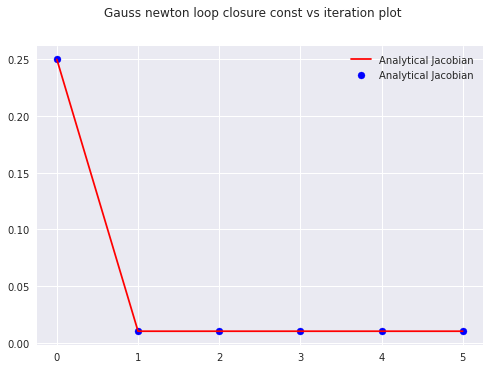

In [135]:

def loop_closure(x_list,U):
    val=(x_list[:,0]+U[4]-x_list[:,4])**2
    plt.scatter(range(len(x_list)),val,color='blue',label='Analytical Jacobian')
    plt.legend(loc="upper right")
    plt.plot(range(len(x_list)),val,color='red',label='Analytical Jacobian')
    plt.legend(loc="upper right")
    plt.suptitle("Gauss newton loop closure const vs iteration plot")
    


loop_closure(analytical,obs_u)

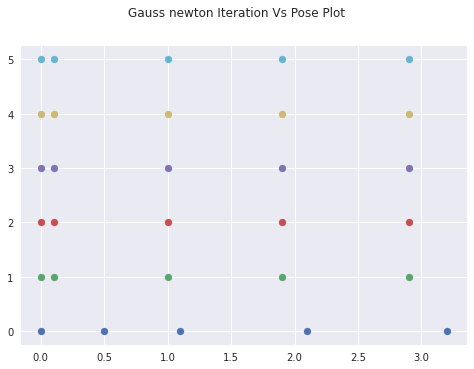

In [136]:
def pose_plot(x_list):
    # plt.clf()
    plt.suptitle("Gauss newton Iteration Vs Pose Plot")
    for _ in range(len(x_list)):
        plt.scatter(x_list[_],[_ for idx in range(len(x_list[_]))],label="Analytical Jacobian")
    plt.show()
pose_plot(analytical)


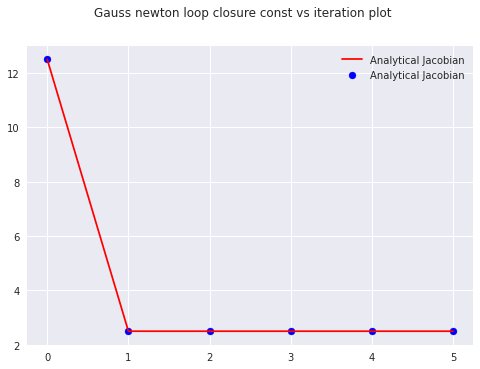

In [137]:
def get_err(X_list):
    global obs_u, info_matrix
    err_list = []
    for X in X_list:
        fx = calc_residual(obs_u, X)
        dota=np.dot(info_matrix,fx)
        err = 0.5 * fx.T @ dota
        err_list.append(err)
    return np.array(err_list)

def error_plot(x_list,gt_x):
    plt.suptitle("Gauss Newton error Vs Iteration Plot")
    val=get_err(x_list)
    plt.scatter(range(len(x_list)),val,color='blue',label='Analytical Jacobian')
    plt.legend(loc="upper right")
    plt.plot(range(len(x_list)),val,color='red',label='Analytical Jacobian')
    plt.legend(loc="upper right")
    plt.suptitle("Gauss newton loop closure const vs iteration plot")
    
error_plot(analytical,jnp.array(gt_x))
